In [ ]:
# Always upgrade pip first
!pip install -U pip

# Make sure the zoo matches your Unsloth build (prevents "torch._inductor" errors)
!pip uninstall -y unsloth_zoo || true
!pip cache purge -q
!pip install --no-cache-dir --upgrade --no-deps unsloth_zoo

# Install unsloth (let it resolve torch/transformers/accelerate/bnb for you)
!pip install --no-cache-dir --upgrade unsloth

# Everything else you need for the NOTEBOOK (no version pins!)
!pip install sentencepiece datasets peft trl wandb scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 13.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 91.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 367.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 331.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 368.7 MB/s  0:00:00
  Attempting uninstall: torchao
    Found existing installation: torchao 0.10.0
    Uninstalling torchao-0.10.0:
      Successfully uninstalled torchao-0.10.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_dataset

PATH = "/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits"

data_files = {
    "train": f"{PATH}/train_v2.csv",
    "validation": f"{PATH}/val.csv",
    "test": f"{PATH}/test.csv"
}

ds = load_dataset("csv", data_files=data_files)

ds

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['fullname', 'label'],
        num_rows: 7240
    })
    validation: Dataset({
        features: ['fullname', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['fullname', 'label'],
        num_rows: 5000
    })
})

In [ ]:
ALLOWED_ANSWERS = {"ethiopian", "non-ethiopian"}

PROMPT_TEMPLATE = """### Instruction:
You will be given a full name. Classify the name into two categories:
1) ethiopian
2) non-ethiopian
Respond with only two words: ethiopian or non-ethiopian

### Input
Name: {}

### Response
{}"""


In [ ]:
#wrapping the datasat with the prompt
def format_for_training(example):
  text = PROMPT_TEMPLATE.format(example['fullname'], example['label'])
  return{"text": text}
ds = ds.map(format_for_training,remove_columns=ds['train'].column_names)

print(ds)

Map:   0%|          | 0/7240 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 7240
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text'],
        num_rows: 5000
    })
})


In [ ]:
from unsloth import FastLanguageModel

MODEL_ID = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit"
MAX_SEQ_LEN = 256

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name     = MODEL_ID,
    max_seq_length = MAX_SEQ_LEN,
    dtype          = None,
    load_in_4bit   = True,
)

# Padding config
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

print("Loaded:", MODEL_ID)
print("EOS token:", tokenizer.eos_token, "| PAD token:", tokenizer.pad_token)

==((====))==  Unsloth 2025.11.3: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Loaded: unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit
EOS token: <|eot_id|> | PAD token: <|eot_id|>


In [ ]:
from unsloth import FastLanguageModel

model = FastLanguageModel.get_peft_model(
    model,
    r = 64,
    target_modules = ["q_proj", "v_proj"],
    lora_alpha = 32,
    lora_dropout = 0.05,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
)

print("LoRA adapters attached.")

LoRA adapters attached.


In [ ]:
# ADD — install & login once per runtime
!pip -q install wandb

import wandb
wandb.login()  # will open a small prompt; paste your API key

# minimal init (rename if you like)
wandb.init(project="EthiopianClassifier", name="version_0.1")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
# === ADD: evaluator ===
import re, numpy as np, pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, accuracy_score

def _normalize_label(raw: str) -> str:
    s = raw.strip().lower().replace("-", " ").replace("_", " ")
    if s.startswith("non ethiopian") or ("non" in s and "ethiopian" in s):
        return "Non-Ethiopian"
    if "ethiopian" in s:
        return "Ethiopian"
    return "Non-Ethiopian"

PROMPT_TEMPLATE = """### Instruction:
You will be given a full name. Classify the name into two categories:
1) ethiopian
2) non-ethiopian
Respond with only two words: ethiopian or non-ethiopian

### Input
Name: {name}

### Response
"""

def _make_prompt(name: str) -> str:
    return PROMPT_TEMPLATE.format(name=name)

def evaluate_df(model, tokenizer, df: pd.DataFrame, batch_size=128, max_length=256):
    # Build prompts + gold
    names = df["fullname"].astype(str).tolist()
    gold  = [_normalize_label(x) for x in df["label"].astype(str).tolist()]
    prompts = [_make_prompt(n) for n in names]

    # Generate
    from unsloth import FastLanguageModel
    FastLanguageModel.for_inference(model)

    preds = []
    for i in tqdm(range(0, len(prompts), batch_size), desc="Eval(generation)"):
        batch = prompts[i:i+batch_size]
        toks = tokenizer(
            batch, return_tensors="pt", padding=True, truncation=True,
            max_length=max_length
        ).to(model.device)

        outs = model.generate(
            **toks,
            max_new_tokens=5, do_sample=False, num_beams=1, use_cache=True,
            eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
        )

        # decode only the generated suffix
        input_len = toks["input_ids"].shape[1]
        dec = tokenizer.batch_decode(outs[:, input_len:], skip_special_tokens=True)
        preds.extend([_normalize_label(x) for x in dec])

    # Metrics
    acc = accuracy_score(gold, preds)
    report = classification_report(
        gold, preds,
        labels=["Non-Ethiopian", "Ethiopian"],
        target_names=["Non-Ethiopian", "Ethiopian"],
        digits=4,
        zero_division=0,
        output_dict=True,
    )

    # Flatten a few handy keys for early stopping / W&B
    metrics = {
        "accuracy": acc,
        "macro_precision": report["macro avg"]["precision"],
        "macro_recall":    report["macro avg"]["recall"],
        "macro_f1":        report["macro avg"]["f1-score"],
        "weighted_precision": report["weighted avg"]["precision"],
        "weighted_recall":    report["weighted avg"]["recall"],
        "weighted_f1":        report["weighted avg"]["f1-score"],
        # class-wise if you want them visible in W&B too:
        "Ethiopian_precision":     report["Ethiopian"]["precision"],
        "Ethiopian_recall":        report["Ethiopian"]["recall"],
        "Ethiopian_f1":            report["Ethiopian"]["f1-score"],
        "NonEthiopian_precision":  report["Non-Ethiopian"]["precision"],
        "NonEthiopian_recall":     report["Non-Ethiopian"]["recall"],
        "NonEthiopian_f1":         report["Non-Ethiopian"]["f1-score"],
    }
    return metrics, preds, gold, report

# === W&B callback ===
import os, random, wandb
from transformers import TrainerCallback
from unsloth import FastLanguageModel

class LLMEarlyStoppingWandbCallback(TrainerCallback):
    def __init__(
        self,
        trainer,                 # <<< pass the trainer object when you build it
        tokenizer,
        eval_df: pd.DataFrame,   # <<< dataframe version of your eval split
        patience: int = 3,
        metric_key: str = "weighted_f1",   # choose: "weighted_f1", "macro_f1", "weighted_recall", etc.
        sample_size: int = 6,
        max_new_tokens: int = 5,
        log_model: str = "checkpoint",
    ):
        self.trainer = trainer
        self.tokenizer = tokenizer
        self.eval_df = eval_df.reset_index(drop=True)
        self.patience = patience
        self.metric_key = metric_key
        self.sample_size = min(sample_size, len(self.eval_df))
        self.max_new_tokens = max_new_tokens
        self.best_metric = -1e9
        self.no_improve = 0
        self.log_model = log_model

        # pick a few samples to show in W&B
        self.sample_rows = (
            self.eval_df.sample(self.sample_size, random_state=42)
            if self.sample_size > 0 else self.eval_df.head(0)
        )

    def on_evaluate(self, args, state, control, **kwargs):
        model = self.trainer.model
        FastLanguageModel.for_inference(model)

        # 1) run our evaluator
        metrics, _, _, report = evaluate_df(
            model=model, tokenizer=self.tokenizer, df=self.eval_df, batch_size=128, max_length=256
        )

        # 2) log to W&B (flatten for nice charts)
        flat = {f"eval/{k}": v for k, v in metrics.items()}
        flat["global_step"] = state.global_step
        wandb.log(flat)

        # pretty print to notebook too (optional)
        print("\nEval metrics:", {k: round(v, 4) for k, v in metrics.items() if isinstance(v, (int, float))})

        # 3) early stopping on chosen metric
        current = float(metrics[self.metric_key])
        if current > self.best_metric:
            self.best_metric = current
            self.no_improve = 0

            # save a "best_<metric>" checkpoint under output_dir/run_name/
            save_dir = os.path.join(args.output_dir, args.run_name, f"best_{self.metric_key}")
            os.makedirs(save_dir, exist_ok=True)
            model.save_pretrained(save_dir)
            self.tokenizer.save_pretrained(save_dir)
            print(f"⬆️  New best {self.metric_key}: {current:.4f} — saved to {save_dir}")
        else:
            self.no_improve += 1
            print(f"⏸️  No improvement on {self.metric_key} ({self.no_improve}/{self.patience})")
            if self.no_improve >= self.patience:
                control.should_training_stop = True
                print(f"🛑 Early stopping — {self.metric_key} didn't improve for {self.patience} evals.")

        # 4) small sample generations table to W&B
        if self.sample_size > 0:
            table = wandb.Table(columns=["name", "generation"])
            for _, row in self.sample_rows.iterrows():
                prompt = PROMPT_TEMPLATE.format(name=row["fullname"])
                toks = self.tokenizer(
                    prompt, return_tensors="pt", padding=True, truncation=True, max_length=256
                ).to(model.device)

                out = model.generate(
                    **toks, max_new_tokens=self.max_new_tokens, do_sample=False, num_beams=1,
                    eos_token_id=self.tokenizer.eos_token_id, pad_token_id=self.tokenizer.pad_token_id
                )
                gen = self.tokenizer.decode(out[0][toks["input_ids"].shape[1]:], skip_special_tokens=True)
                table.add_data(row["fullname"], gen)
            wandb.log({"eval/sample_predictions": table})

        # go back to train mode
        FastLanguageModel.for_training(model)

        return control

In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback
from trl import SFTTrainer

OUTPUT_DIR = "/content/drive/MyDrive/AMAC/EthiopianClassifier/ethiopian_classifier_outputs_v2"

args = TrainingArguments(
    run_name="ethiopian_classifier_v0.2",
    output_dir=OUTPUT_DIR,

    # core training
    num_train_epochs=3,
    per_device_train_batch_size=128,
    gradient_accumulation_steps=1,
    learning_rate=2e-4,
    weight_decay=0.01,

    # precision
    fp16=False,
    bf16=True,

    #logging / eval / saving
    logging_strategy="steps",
    logging_steps=40,
    eval_strategy="epoch",
    save_strategy="no",
    save_total_limit=2,
    report_to="wandb",
    load_best_model_at_end=False,
    seed=3407,
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    dataset_text_field="text",
    max_seq_length=256,
    packing=False,
    args=args,
)

#eval_df = pd.read_csv("/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/val.csv")
eval_df = pd.read_csv("/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/val_10pct_eth.csv")

wandb_cb = LLMEarlyStoppingWandbCallback(
    trainer=trainer,
    tokenizer=tokenizer,
    eval_df=eval_df,
    patience=3,
    metric_key="Ethiopian_f1",
    sample_size=6,
    max_new_tokens=5,
)

trainer.add_callback(wandb_cb)

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/7240 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

# Save final model
trainer.model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("Model saved to:", OUTPUT_DIR)

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,240 | Num Epochs = 3 | Total steps = 171
O^O/ \_/ \    Batch size per device = 128 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (128 x 1 x 1) = 128
 "-____-"     Trainable parameters = 27,262,976 of 8,057,524,224 (0.34% trained)


Epoch,Training Loss,Validation Loss
1,0.711500,0.374195
2,0.336700,0.300977
3,0.248900,0.300027


Unsloth: Will smartly offload gradients to save VRAM!


Eval(generation):   0%|          | 0/40 [00:00<?, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Eval metrics: {'accuracy': 0.9526, 'macro_precision': 0.7526, 'macro_recall': 0.6757, 'macro_f1': 0.7062, 'weighted_precision': 0.9458, 'weighted_recall': 0.9526, 'weighted_f1': 0.9483, 'Ethiopian_precision': 0.538, 'Ethiopian_recall': 0.368, 'Ethiopian_f1': 0.4371, 'NonEthiopian_precision': 0.9673, 'NonEthiopian_recall': 0.9834, 'NonEthiopian_f1': 0.9753}
⬆️  New best Ethiopian_f1: 0.4371 — saved to /content/drive/MyDrive/AMAC/EthiopianClassifier/ethiopian_classifier_outputs_v2/ethiopian_classifier_v0.2/best_Ethiopian_f1


Eval(generation):   0%|          | 0/40 [00:00<?, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Eval metrics: {'accuracy': 0.8722, 'macro_precision': 0.5185, 'macro_recall': 0.5329, 'macro_f1': 0.52, 'weighted_precision': 0.91, 'weighted_recall': 0.8722, 'weighted_f1': 0.89, 'Ethiopian_precision': 0.0835, 'Ethiopian_recall': 0.156, 'Ethiopian_f1': 0.1088, 'NonEthiopian_precision': 0.9535, 'NonEthiopian_recall': 0.9099, 'NonEthiopian_f1': 0.9312}
⏸️  No improvement on Ethiopian_f1 (1/3)


Eval(generation):   0%|          | 0/40 [00:00<?, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Eval metrics: {'accuracy': 0.9136, 'macro_precision': 0.5498, 'macro_recall': 0.5509, 'macro_f1': 0.5504, 'weighted_precision': 0.9146, 'weighted_recall': 0.9136, 'weighted_f1': 0.9141, 'Ethiopian_precision': 0.1445, 'Ethiopian_recall': 0.148, 'Ethiopian_f1': 0.1462, 'NonEthiopian_precision': 0.9551, 'NonEthiopian_recall': 0.9539, 'NonEthiopian_f1': 0.9545}
⏸️  No improvement on Ethiopian_f1 (2/3)
Model saved to: /content/drive/MyDrive/AMAC/EthiopianClassifier/ethiopian_classifier_outputs_v2


In [ ]:
# Good function for evaluation for manual runs.

from unsloth import FastLanguageModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def normalize_label(raw: str) -> str:
    """
    Normalize raw labels into exactly 'Ethiopian' or 'Non-Ethiopian'
    """
    s = str(raw).strip().lower().replace("-", " ").replace("_", " ")
    if s.startswith("non ethiopian") or ("non" in s and "ethiopian" in s):
        return "Non-Ethiopian"
    if s.startswith("ethiopian") or "ethiopian" in s:
        return "Ethiopian"
    return "Non-Ethiopian"  # default fallback


PROMPT_TEMPLATE = """### Instruction:
You will be given a full name. Classify the name into two categories:
1) ethiopian
2) non-ethiopian
Respond with only two words: ethiopian or non-ethiopian

### Input
Name: {name}

### Response
"""

def make_prompt(name: str) -> str:
    return PROMPT_TEMPLATE.format(name=name)

def evaluate_on_csv(
    model,
    tokenizer,
    csv_path: str,
    split_name: str = "test",
    batch_size: int = 128,
    max_length: int = 256,
    plot: bool = True,
):
    # 1) Load data
    df = pd.read_csv(csv_path)
    names = df["fullname"].astype(str).tolist()
    gold  = [normalize_label(x) for x in df["label"].astype(str)]
    prompts = [make_prompt(n) for n in names]

    # 2) Generate predictions (batched)
    FastLanguageModel.for_inference(model)
    preds = []
    for i in tqdm(range(0, len(prompts), batch_size), desc=f"Evaluating ({split_name})"):
        batch = prompts[i:i+batch_size]
        toks = tokenizer(
            batch, return_tensors="pt", padding=True, truncation=True,
            max_length=max_length
        ).to(model.device)

        outs = model.generate(
            **toks,
            max_new_tokens=5,
            do_sample=False,
            num_beams=1,
            use_cache=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

        # only new tokens (exclude the prompt)
        input_len = toks["input_ids"].shape[1]
        gen_only = outs[:, input_len:]
        dec = tokenizer.batch_decode(gen_only, skip_special_tokens=True)
        preds.extend([normalize_label(x) for x in dec])

    # 3) Metrics
    acc = accuracy_score(gold, preds)
    print(f"\nAccuracy ({split_name}): {acc:.4f}\n")

    report = classification_report(
        gold, preds,
        labels=["Non-Ethiopian", "Ethiopian"],
        target_names=["Non-Ethiopian", "Ethiopian"],
        digits=4,
        zero_division=0,
        output_dict=True,
    )
    print("Classification report (\033[1m" + split_name + "\033[0m):\n")
    print(pd.DataFrame(report).transpose())

    # 4) Confusion matrix (+ optional plot)
    cm = confusion_matrix(gold, preds, labels=["Non-Ethiopian", "Ethiopian"])
    if plot:
        cm_df = pd.DataFrame(
            cm,
            index=["True Non-Ethiopian", "True Ethiopian"],
            columns=["Pred Non-Ethiopian", "Pred Ethiopian"]
        )
        sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)
        plt.title(f"Confusion Matrix — Ethiopian Classifier ({split_name})")
        plt.ylabel("True label"); plt.xlabel("Predicted label")
        plt.tight_layout(); plt.show()

    # 5) Misclassifications preview
    errors = [(n, g, p) for n, g, p in zip(names, gold, preds) if g != p]
    print("Misclassifications:", len(errors))
    if errors:
        display(pd.DataFrame(errors[:25], columns=["Name", "True", "Pred"]))

    return {
        "accuracy": acc,
        "report": report,
        "confusion_matrix": cm,
        "preds": preds,
        "gold": gold,
        "errors": errors,
    }

==((====))==  Unsloth 2025.11.3: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Loaded model + adapter!


Evaluating (test):   0%|          | 0/40 [00:00<?, ?it/s]


Accuracy (test): 0.9512

Classification report (test):

               precision    recall  f1-score    support
Non-Ethiopian   0.988720  0.959579  0.973932  4750.0000
Ethiopian       0.507692  0.792000  0.618750   250.0000
accuracy        0.951200  0.951200  0.951200     0.9512
macro avg       0.748206  0.875789  0.796341  5000.0000
weighted avg    0.964669  0.951200  0.956173  5000.0000


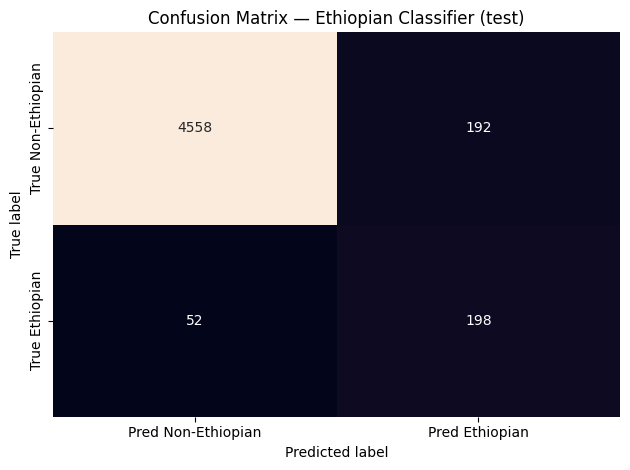

Misclassifications: 244


,Name,True,Pred
0,amira mohamed,Non-Ethiopian,Ethiopian
1,talha sharif,Ethiopian,Non-Ethiopian
2,hashim seid,Non-Ethiopian,Ethiopian
3,younis ali,Non-Ethiopian,Ethiopian
4,rahma hassan,Non-Ethiopian,Ethiopian
5,sabria khalid,Ethiopian,Non-Ethiopian
6,yetnebersh belay,Non-Ethiopian,Ethiopian
7,mohammed mahmood,Non-Ethiopian,Ethiopian
8,muna abdulqadir,Non-Ethiopian,Ethiopian
9,abdulrahman ghalib,Non-Ethiopian,Ethiopian


In [ ]:
import os
from transformers import AutoTokenizer
from peft import PeftModel
from unsloth import FastLanguageModel
import seaborn as sns
import matplotlib.pyplot as plt

BASE_4BIT = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit"

CKPT_PATH = (
    "/content/drive/MyDrive/AMAC/EthiopianClassifier/"
    "ethiopian_classifier_outputs_v2/ethiopian_classifier_v0.2/best_Ethiopian_f1"
)

assert os.path.isdir(CKPT_PATH), f"Checkpoint dir not found: {CKPT_PATH}"

# ------------------------------------------------------
# 1) ALWAYS load tokenizer from the **base model**
#    NOT from the LoRA checkpoint folder.
# ------------------------------------------------------
tok = AutoTokenizer.from_pretrained(
    BASE_4BIT,
    use_fast=True,
)

# ------------------------------------------------------
# 2) Load base model in 4-bit
# ------------------------------------------------------
model, tokenizer_unused = FastLanguageModel.from_pretrained(
    model_name=BASE_4BIT,
    max_seq_length=256,
    load_in_4bit=True,
)

# ------------------------------------------------------
# 3) Attach LoRA adapter (two methods supported)
# ------------------------------------------------------
try:
    # Unsloth style
    model.load_adapter(CKPT_PATH)
except Exception:
    # PEFT style
    model = PeftModel.from_pretrained(
        model,
        CKPT_PATH,
        local_files_only=True,
    )

print("Loaded model + adapter!")

# ------------------------------------------------------
# 4) Evaluate on CSV (your custom evaluator)
# ------------------------------------------------------
_ = evaluate_on_csv(
    model=model,
    tokenizer=tok,
    csv_path="/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/val.csv",
    split_name="test",
    batch_size=128,
    max_length=256,
    plot=True,
)

Eval(generation):   0%|          | 0/40 [00:00<?, ?it/s]

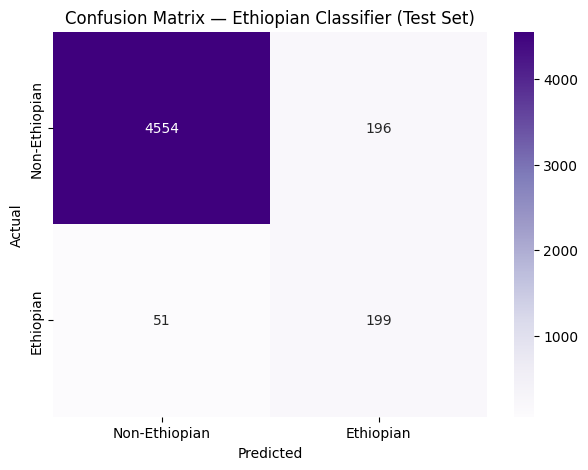


Classification Report:

Non-Ethiopian:  Precision=0.9889, Recall=0.9587, F1=0.9736
Ethiopian:  Precision=0.5038, Recall=0.7960, F1=0.6171

Overall Accuracy: 0.9506


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- LOAD THE TEST CSV ---
test_df = pd.read_csv(
    "/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/test.csv"
)

# --- Get predictions + gold labels using your evaluator ---
metrics, preds, gold, report = evaluate_df(
    model=model,
    tokenizer=tok,
    df=test_df,
    batch_size=128,
    max_length=256,
)

# --- Convert to numpy arrays ---
gold = np.array(gold)
preds = np.array(preds)

# --- Confusion Matrix ---
cm = confusion_matrix(
    gold,
    preds,
    labels=["Non-Ethiopian", "Ethiopian"]
)

# --- Plot ---
plt.figure(figsize=(7,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["Non-Ethiopian", "Ethiopian"],
    yticklabels=["Non-Ethiopian", "Ethiopian"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Ethiopian Classifier (Test Set)")
plt.show()

# --- Print classification report cleanly ---
print("\nClassification Report:\n")
for cls in ["Non-Ethiopian", "Ethiopian"]:
    print(f"{cls}:  Precision={report[cls]['precision']:.4f}, "
          f"Recall={report[cls]['recall']:.4f}, "
          f"F1={report[cls]['f1-score']:.4f}")
print("\nOverall Accuracy:", metrics["accuracy"])

In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/train.csv")
eval_df = pd.read_csv("/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/test.csv")
eval_df2 = pd.read_csv("/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/val_10pct_eth.csv")

print("VAL DISTRIBUTION:\n", eval_df["label"].value_counts(), "\n")
print("TEST DISTRIBUTION:\n", test_df["label"].value_counts(), "\n")
print("TRAIN DISTRIBUTION:\n", train_df["label"].value_counts(), "\n")
print("TRAIN DISTRIBUTION:\n", eval_df2["label"].value_counts(), "\n")

VAL DISTRIBUTION:
 label
non-ethiopian    4750
ethiopian         250
Name: count, dtype: int64 

TEST DISTRIBUTION:
 label
non-ethiopian    4750
ethiopian         250
Name: count, dtype: int64 

TRAIN DISTRIBUTION:
 label
non-ethiopian    1748
ethiopian        1743
Name: count, dtype: int64 

TRAIN DISTRIBUTION:
 label
non-ethiopian    4750
ethiopian         250
Name: count, dtype: int64 



In [ ]:
import pandas as pd

VAL_PATH = "/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/val.csv"
OUT_PATH = "/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/val_10pct_eth.csv"

df = pd.read_csv(VAL_PATH)

# 1) Identify Ethiopian vs Non-Ethiopian rows (robust to capitalization / variants)
is_eth = df["label"].astype(str).str.strip().str.lower().str.contains("ethio")
eth = df[is_eth].copy()
non = df[~is_eth].copy()

print("Ethiopian rows :", len(eth))
print("Non-Ethiopian rows:", len(non))

# 2) We want Ethiopians ≈ 10% of eval
#    If we keep ALL Ethiopians, we downsample Non-Ethiopians to 9x that size
target_non = min(len(non), len(eth) * 9)

non_sampled = non.sample(n=target_non, random_state=42)

val_10 = pd.concat([eth, non_sampled], axis=0)
val_10 = val_10.sample(frac=1.0, random_state=42).reset_index(drop=True)  # shuffle

print("New eval size:", len(val_10))
print("New Ethiopian ratio:", len(eth) / len(val_10))

val_10.to_csv(OUT_PATH, index=False)
print("Saved new eval to:", OUT_PATH)

Ethiopian rows : 5000
Non-Ethiopian rows: 0
New eval size: 5000
New Ethiopian ratio: 1.0
Saved new eval to: /content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/val_10pct_eth.csv


In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/AMAC/clean/nonsomali_20k_canonical.csv"

df = pd.read_csv(path)

print("Columns:", df.columns.tolist())
print("\nSample rows:")
print(df.head())

print("\nUnique label values:", df['label'].unique())
print("Unique source values:", df['source'].unique())

print("\nCount by source:")
print(df['source'].value_counts())

Columns: ['full_name', 'source', 'label']

Sample rows:
          full_name   source       label
0   lyndsi odenborg       US  non-somali
1    nabeel mushtaq  MENA_EA  non-somali
2   milosz orlinski    OTHER  non-somali
3  mohammad ghaffar  MENA_EA  non-somali
4     disha zambani    SASIA  non-somali

Unique label values: ['non-somali']
Unique source values: ['US' 'MENA_EA' 'OTHER' 'SASIA' 'WEU']

Count by source:
source
US         9853
WEU        3884
MENA_EA    2824
SASIA      1975
OTHER       999
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np

# ------------------------- PATHS -------------------------
root = "/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets"
splits = f"{root}/Splits"

train_path = f"{splits}/train.csv"   # THIS is the correct Ethiopian set
gpt_path = f"{root}/ethiopian_muslim_3000_cleaned.csv"
non20k_path = "/content/drive/MyDrive/AMAC/clean/nonsomali_20k_canonical.csv"

save_path = f"{splits}/train_v2.csv"

# ------------------------- LOAD DATA -------------------------
train_df = pd.read_csv(train_path)
gpt_df = pd.read_csv(gpt_path)
non_df = pd.read_csv(non20k_path)

# ------------------------- NORMALIZE COLUMN NAMES -------------------------
def normalize(df):
    df = df.copy()
    if "full_name" in df.columns:
        df.rename(columns={"full_name": "fullname"}, inplace=True)
    return df

train_df = normalize(train_df)
gpt_df = normalize(gpt_df)
non_df = normalize(non_df)

# ------------------------- KEEP ONLY 2-WORD NAMES -------------------------
def keep_two_words(df):
    return df[df["fullname"].str.split().apply(len) == 2]

train_df = keep_two_words(train_df)
gpt_df = keep_two_words(gpt_df)
non_df = keep_two_words(non_df)

# ------------------------- FIX LABELS -------------------------
train_df = train_df[train_df["label"] == "ethiopian"]  # keep only Ethiopians
gpt_df["label"] = "ethiopian"
non_df["label"] = "non-ethiopian"

# ------------------------- ETHIOPIAN COUNT -------------------------
ethiopians = pd.concat([train_df, gpt_df], ignore_index=True)
ETH_COUNT = len(ethiopians)

print("Ethiopians =", ETH_COUNT)

# ------------------------- NON-ETHIOPIAN SAMPLING -------------------------
US = non_df[non_df["source"] == "US"]
OTHERS = non_df[non_df["source"] != "US"]

half = ETH_COUNT // 2

# 50% Americans
us_take = US.sample(n=half, random_state=42)

# Round-robin across remaining 4 regions
groups = [g for _, g in OTHERS.groupby("source")]

needed = ETH_COUNT - half
picked = []

while len(picked) < needed:
    for g in groups:
        if len(g) > 0 and len(picked) < needed:
            sample = g.sample(1, random_state=np.random.randint(0, 99999))
            picked.append(sample)
            g.drop(sample.index, inplace=True)

other_take = pd.concat(picked)

non_ethiopians = pd.concat([us_take, other_take], ignore_index=True)

# ------------------------- BUILD TRAIN V2 -------------------------
train_v2 = pd.concat([
    ethiopians[["fullname", "label"]],
    non_ethiopians[["fullname", "label"]],
], ignore_index=True)

train_v2 = train_v2.sample(frac=1, random_state=42).reset_index(drop=True)

# ------------------------- SAVE -------------------------
train_v2.to_csv(save_path, index=False)

print("Saved to:", save_path)
print(train_v2["label"].value_counts())

Ethiopians = 4447
Saved to: /content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/train_v2.csv
label
non-ethiopian    4447
ethiopian        4447
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np

# ------------------------- PATHS -------------------------
root = "/content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets"

ethiopian_path = f"{root}/ethiopian_dataset.csv"
gpt_path = f"{root}/ethiopian_muslim_3000_cleaned.csv"
nonsomali_path = "/content/drive/MyDrive/AMAC/clean/nonsomali_20k_canonical.csv"

save_path = f"{root}/Splits/train_v2.csv"

# ------------------------- LOAD -------------------------
eth_df = pd.read_csv(ethiopian_path)
gpt_df = pd.read_csv(gpt_path)
non_df = pd.read_csv(nonsomali_path)

# ------------------------- NORMALIZE COL NAMES -------------------------
def normalize(df):
    df = df.copy()
    if "full_name" in df.columns:
        df.rename(columns={"full_name": "fullname"}, inplace=True)
    return df

eth_df = normalize(eth_df)
gpt_df = normalize(gpt_df)
non_df = normalize(non_df)

# ------------------------- KEEP ONLY 2-WORD NAMES -------------------------
def keep_two_words(df):
    return df[df["fullname"].str.strip().str.split().apply(len) == 2]

eth_df = keep_two_words(eth_df)
gpt_df = keep_two_words(gpt_df)
non_df = keep_two_words(non_df)

# ------------------------- REMOVE DUPLICATES ACROSS ETH + GPT -------------------------
combined_eth = pd.concat([eth_df, gpt_df], ignore_index=True)
combined_eth = combined_eth.drop_duplicates(subset=["fullname"], keep="first")
combined_eth["label"] = "ethiopian"

ethiopian_final = combined_eth.copy()
ethiopian_count = len(ethiopian_final)

print("Unique Ethiopian names =", ethiopian_count)

# ------------------------- NON-SOMALI SAMPLING -------------------------
non_df["label"] = "non-ethiopian"

us_df = non_df[non_df["source"] == "US"]
other_df = non_df[non_df["source"] != "US"]

half = ethiopian_count // 2
us_take = us_df.sample(n=half, random_state=42)
other_take = other_df.sample(n=ethiopian_count - half, random_state=42)

balanced_non = pd.concat([us_take, other_take], ignore_index=True)

# ------------------------- BUILD TRAIN V2 -------------------------
train_v2 = pd.concat([
    ethiopian_final[["fullname", "label"]],
    balanced_non[["fullname", "label"]],
], ignore_index=True)

train_v2 = train_v2.sample(frac=1, random_state=42).reset_index(drop=True)
train_v2.to_csv(save_path, index=False)

print("Saved to:", save_path)
print(train_v2["label"].value_counts())

Unique Ethiopian names = 3620
Saved to: /content/drive/MyDrive/AMAC/EthiopianClassifier/Datasets/Splits/train_v2.csv
label
ethiopian        3620
non-ethiopian    3620
Name: count, dtype: int64
